# Importing Modules and loading data

In [1]:
import sys
import os
sys.path.append('./Scripts')
sys.path.append('./Files')
sys.path.append('./Datasets')

In [2]:
os.system('pip install nltk')
os.system('pip install openpyxl')
os.system('pip install emot')

0

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import openpyxl
import emot
import pickle

# from google.colab import files
from nltk.corpus import stopwords
import nltk
import seaborn as sns
nltk.download('punkt')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

from Sequencer import Sequencer
from helper_fns import write_dict
from helper_fns import read_dict

from dataCleaner import clean_arabic_text

import ArStemmerLib as lib
import lexicon
from lexicon import calc_lexicon

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\youss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\youss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
data_path = "Text Preprocessing Experimentations/exp1_rtp_rl_re_cat_rl_qalsadi.csv"

In [5]:
df = pd.read_csv(data_path)
df.dropna(inplace=True)

In [6]:
df.head()

,tweet,label
0,الاوليمبياد الجايه هكون لاس ف الكليه,none
1,عجز الموازنه وصل ل من ناتج محل عنى لاس قلا من ...,anger
2,كت نيل ف حظ هباب,sadness
3,جميع أراد تحقيق اهدافنا لكن تونس تالقت في حراس...,joy
4,الاوليمبياد نظام مختلف مواعيد مونديال مكانتش م...,none


In [7]:
df.head()

,tweet,label
0,الاوليمبياد الجايه هكون لاس ف الكليه,none
1,عجز الموازنه وصل ل من ناتج محل عنى لاس قلا من ...,anger
2,كت نيل ف حظ هباب,sadness
3,جميع أراد تحقيق اهدافنا لكن تونس تالقت في حراس...,joy
4,الاوليمبياد نظام مختلف مواعيد مونديال مكانتش م...,none


In [8]:
# tweets_df = pd.read_csv('Datasets/tweets_sns2.csv')
# keep_regex = "[Vv]odafone|VODAFONE|فودافون|[Ee]tisalat|ETISALAT|اتصالات|[Oo]range|ORANGE|اورانج|موبينيل|إتصالات|أورانج"
# remove_regex = "لون"
# drop_indeces = tweets_df[(tweets_df['text'].str.contains(keep_regex)==False) | (tweets_df['text'].str.contains(remove_regex)==True)].index
# tweets_df.drop(drop_indeces, inplace=True)
# tweets= tweets_df['text'].copy()
# tweets2 = df['tweet'].copy()
# tokens1 = set(nltk.word_tokenize(' '.join(tweets.to_numpy().flatten())))
# tokens2 = set(nltk.word_tokenize(' '.join(tweets2.to_numpy().flatten())))
# def tweet_filter(tweet: str, bucket: set[str]) -> bool:
#     tokens = set(nltk.word_tokenize(tweet))
#     inclusion_ratio =  len(tokens.intersection(bucket)) / len(tokens)
#     return inclusion_ratio >= 0.5

# filtered_tweets = tweets.to_numpy()[[tweet_filter(x, tokens2) for x in tweets.to_numpy()]]

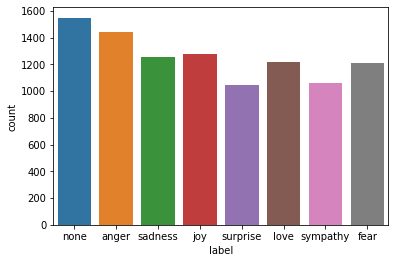

In [8]:
_ = sns.countplot(x='label', data=df)

# Preparing Vectorized data 

## Count Vectorizer

In [23]:
count_vec = CountVectorizer(ngram_range=(1,1))

In [24]:
count_data = count_vec.fit_transform(df['tweet'])

## TF-IDF

In [25]:
tfidf_vec = TfidfVectorizer()

In [26]:
tfidf_data = tfidf_vec.fit_transform(df['tweet'])

## Word2Vec

In [27]:
def embed_data(df, embeddings_dict, embedding_padding):

    sequencer = Sequencer(df['tweet'], embeddings_dict, embedding_padding)

    embeddings_matrix = []
    for tweet in df['tweet']:
        tweet_vec = sequencer.padder(sequencer.text_to_vec(tweet))
        embeddings_matrix.append(tweet_vec)
    embeddings_matrix = np.array(embeddings_matrix)

    embedded_data = pd.DataFrame(embeddings_matrix)

    for i in range(embedding_padding):
        embedded_data[i] =(embedded_data[i] - embedded_data[i].mean() ) / embedded_data[i].std()
    
    return embedded_data

### Skip-Gram

In [30]:
skipgram_path = "Word Embeddings/sg_dict_exp1_5_2_100.txt"

In [31]:
skipgram_dict = read_dict(skipgram_path)

In [32]:
sg_padding = 1000

In [33]:
skipgram_data = embed_data(df, skipgram_dict, sg_padding)

In [34]:
skipgram_data.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.666788,-0.011577,-1.735281,-0.138475,0.812687,-1.010818,-2.172168,1.948643,-2.446131,-0.868050,...,-0.918391,-0.928069,0.122925,0.379345,-1.107691,-0.880356,-0.891465,0.792520,-0.327571,0.252153
1,-0.682653,0.302772,-0.214432,-0.608642,0.472096,0.020578,-0.778548,0.370417,0.328288,0.383659,...,0.405429,0.924907,-0.471054,-0.773833,1.014965,0.120083,0.286835,-0.277748,-1.162240,-0.113887
2,-0.015187,-0.351706,-0.285157,-0.436838,0.523360,-0.565530,-0.732081,0.086743,-0.191183,0.252277,...,-0.918391,-0.928069,0.122925,0.379345,-1.107691,-0.880356,-0.891465,0.792520,-0.327571,0.252153
3,-0.602136,0.833356,0.497211,-0.694100,0.618843,-0.017377,-0.698268,-0.522158,0.485919,0.737001,...,-0.918391,-0.928069,0.122925,0.379345,-1.107691,-0.880356,-0.891465,0.792520,-0.327571,0.252153
4,1.666788,-0.011577,-1.735281,-0.138475,0.812687,-1.010818,-2.172168,1.948643,-2.446131,-0.868050,...,-0.918391,-0.928069,0.122925,0.379345,-1.107691,-0.880356,-0.891465,0.792520,-0.327571,0.252153


### CBOW

In [35]:
cbow_path = "Word Embeddings/cb_dict_exp1_5_2_100.txt"

In [36]:
cbow_dict = read_dict(cbow_path)

In [37]:
cb_padding = 1000

In [38]:
cbow_data = embed_data(df, cbow_dict, cb_padding)

In [39]:
cbow_data.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,3.840167,-0.683009,0.277959,0.573153,-1.796662,-0.868516,0.092762,0.617435,-2.188992,-2.393079,...,-0.986865,-0.922587,-0.304062,0.422238,-1.006567,-0.964970,-0.960525,0.868116,-0.746821,-0.111363
1,0.176389,-1.186505,-0.619490,-0.689793,-0.709427,1.229412,-1.140765,-1.139373,1.162884,0.989851,...,1.115809,1.584304,1.022257,-1.242157,1.363939,1.043546,1.662100,-0.953393,0.384009,0.106576
2,-0.003709,-0.668620,-0.347880,-0.621316,-0.053664,0.601890,-0.708069,-0.645038,0.658213,0.695270,...,-0.986865,-0.922587,-0.304062,0.422238,-1.006567,-0.964970,-0.960525,0.868116,-0.746821,-0.111363
3,-0.167948,0.488332,0.889346,0.460766,0.027175,-0.586057,0.340872,0.421808,-0.419765,-0.314134,...,-0.986865,-0.922587,-0.304062,0.422238,-1.006567,-0.964970,-0.960525,0.868116,-0.746821,-0.111363
4,3.840167,-0.683009,0.277959,0.573153,-1.796662,-0.868516,0.092762,0.617435,-2.188992,-2.393079,...,-0.986865,-0.922587,-0.304062,0.422238,-1.006567,-0.964970,-0.960525,0.868116,-0.746821,-0.111363


# Splitting data

In [41]:
X_train_tfidf,X_test_tfidf,Y_train_tfidf,Y_test_tfidf = train_test_split(tfidf_data, df['label'], test_size=0.25, random_state=1)

In [42]:
X_train_count,X_test_count,Y_train_count,Y_test_count = train_test_split(count_data, df['label'], test_size=0.25, random_state=1)

In [43]:
X_train_sg ,X_test_sg ,Y_train_sg ,Y_test_sg  = train_test_split(skipgram_data, df['label'], test_size=0.25, random_state=1)

In [44]:
X_train_cb ,X_test_cb ,Y_train_cb ,Y_test_cb  = train_test_split(cbow_data, df['label'], test_size=0.25, random_state=1)

In [45]:
X_train ,X_test ,Y_train ,Y_test  = train_test_split(df['tweet'], df['label'], test_size=0.25, random_state=1)

In [46]:
Y_test_tfidf.head()

923         fear
8528        none
3121        fear
3487    sympathy
5856        none
Name: label, dtype: object

In [15]:
# le = LabelEncoder()
# Y_test_tfidf = le.fit_transform(Y_test_tfidf)
# Y_test_count = le.fit_transform(Y_test_count)
# Y_test = le.fit_transform(Y_test)
# Y_train_tfidf = le.fit_transform(Y_train_tfidf)
# Y_train_count = le.fit_transform(Y_train_count)
# Y_train = le.fit_transform(Y_train)

# Modelling

## Naive Bayes

In [47]:
cl = MultinomialNB()

### Lexicon + Count Vectorizer

In [48]:
#calculate the lexicon
tweet_train_lex = []
for tweet in X_train:
    tweet_train_lex.append(calc_lexicon(u"%s" %tweet))

tweet_test_lex = []
for tweet in X_test:
    tweet_test_lex.append(calc_lexicon(u"%s" %tweet))

In [49]:
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
tweet_lex_train_sparse = csr_matrix(tweet_train_lex)
tweet_lex_test_sparse = csr_matrix(tweet_test_lex)
tweet_lex_test_sparse

<2514x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2284 stored elements in Compressed Sparse Row format>

In [50]:
train_feature_matrix = hstack((X_train_count, tweet_lex_train_sparse))
test_feature_matrix = hstack((X_test_count, tweet_lex_test_sparse))
test_feature_matrix

<2514x18066 sparse matrix of type '<class 'numpy.float64'>'
	with 33425 stored elements in Compressed Sparse Row format>

In [51]:
nb_lexicon = cl.fit(train_feature_matrix,Y_train)
predicted = cl.predict(test_feature_matrix)
acc = accuracy_score(Y_test,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test,predicted))

accuracy = 62.88782816229117%
              precision    recall  f1-score   support

       anger       0.64      0.69      0.67       371
        fear       0.82      0.84      0.83       292
         joy       0.56      0.35      0.43       307
        love       0.60      0.80      0.69       281
        none       0.53      0.90      0.66       395
     sadness       0.49      0.33      0.39       301
    surprise       0.71      0.24      0.35       279
    sympathy       0.80      0.80      0.80       288

    accuracy                           0.63      2514
   macro avg       0.64      0.62      0.60      2514
weighted avg       0.64      0.63      0.61      2514



In [52]:
nb_lex_model_path = 'Models/nb_lexicon_model.sav'
pickle.dump(nb_lexicon, open(nb_lex_model_path,'wb'))

### TF-IDF

In [53]:
nb_tfidf = cl.fit(X_train_tfidf, Y_train_tfidf)
p = cl.predict(X_test_tfidf)
acc = accuracy_score(Y_test_tfidf,p)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test,p))

accuracy = 60.501193317422434%
              precision    recall  f1-score   support

       anger       0.63      0.63      0.63       371
        fear       0.81      0.84      0.82       292
         joy       0.59      0.33      0.42       307
        love       0.60      0.79      0.68       281
        none       0.44      0.94      0.60       395
     sadness       0.58      0.29      0.39       301
    surprise       0.86      0.16      0.27       279
    sympathy       0.87      0.74      0.80       288

    accuracy                           0.61      2514
   macro avg       0.67      0.59      0.58      2514
weighted avg       0.66      0.61      0.58      2514



In [54]:
nb_tfidf_model_path = 'Models/nb_tfidf_model.sav'
pickle.dump(nb_tfidf, open(nb_tfidf_model_path,'wb'))

### Lexicon + TF-IDF

In [55]:
train_feature_matrix_tf = hstack((X_train_tfidf, tweet_lex_train_sparse))
test_feature_matrix_tf = hstack((X_test_tfidf, tweet_lex_test_sparse))
test_feature_matrix_tf

<2514x18066 sparse matrix of type '<class 'numpy.float64'>'
	with 33425 stored elements in Compressed Sparse Row format>

In [56]:
nb_lex_tfidf = cl.fit(train_feature_matrix_tf,Y_train)
predicted = cl.predict(test_feature_matrix_tf)
acc = accuracy_score(Y_test,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test,predicted))

accuracy = 54.97215592680986%
              precision    recall  f1-score   support

       anger       0.42      0.81      0.55       371
        fear       0.84      0.67      0.75       292
         joy       0.51      0.38      0.43       307
        love       0.52      0.77      0.62       281
        none       0.51      0.73      0.60       395
     sadness       0.47      0.20      0.28       301
    surprise       0.88      0.10      0.19       279
    sympathy       0.89      0.60      0.72       288

    accuracy                           0.55      2514
   macro avg       0.63      0.53      0.52      2514
weighted avg       0.62      0.55      0.52      2514



In [57]:
nb_lex_tfidf_model_path = 'Models/nb_lex_tfidf_model.sav'
pickle.dump(nb_lex_tfidf, open(nb_lex_tfidf_model_path,'wb'))

## Logistic Regression

### TF-IDF

In [58]:
lg =  LogisticRegression(max_iter=1000)

In [59]:
# make param grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# create and fit the model
model = GridSearchCV(lg, param_grid, cv=10)

In [60]:
model.fit(X_train_tfidf,Y_train_tfidf)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [61]:
# make prediction and print accuracy
prediction = model.predict(X_test_tfidf)
print ('accuracy = '+str(accuracy_score(Y_test_tfidf, prediction)*100)+'%')

accuracy = 65.11535401750199%


In [63]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

       anger       0.56      0.73      0.64       371
        fear       0.98      0.83      0.90       292
         joy       0.52      0.46      0.49       307
        love       0.69      0.71      0.70       281
        none       0.61      0.89      0.72       395
     sadness       0.48      0.37      0.42       301
    surprise       0.67      0.36      0.47       279
    sympathy       0.82      0.77      0.79       288

    accuracy                           0.65      2514
   macro avg       0.67      0.64      0.64      2514
weighted avg       0.66      0.65      0.64      2514



In [64]:
lg_model_path = 'Models/exp1_lg_tfidf_model.sav'
pickle.dump(model, open(lg_model_path,'wb'))

### Lexicon + Count Vectorizer

In [65]:
lg_lexicon = model.fit(train_feature_matrix,Y_train)
prediction = model.predict(test_feature_matrix)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.65
              precision    recall  f1-score   support

       anger       0.66      0.68      0.67       371
        fear       0.98      0.83      0.90       292
         joy       0.49      0.54      0.51       307
        love       0.70      0.69      0.70       281
        none       0.61      0.89      0.73       395
     sadness       0.46      0.36      0.40       301
    surprise       0.61      0.39      0.48       279
    sympathy       0.79      0.76      0.78       288

    accuracy                           0.65      2514
   macro avg       0.66      0.64      0.64      2514
weighted avg       0.66      0.65      0.65      2514



In [66]:
lg_lexicon_model_path = 'Models/lg_lexicon_model.sav'
pickle.dump(lg_lexicon, open(lg_lexicon_model_path,'wb'))

## Complement Naive Bayes

### TF-IDF

In [67]:
CNB = ComplementNB()

In [68]:
CNB.fit(X_train_tfidf, Y_train_tfidf)

ComplementNB()

In [69]:
predicted = CNB.predict(X_test_tfidf)
acc = accuracy_score(Y_test_tfidf,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test_tfidf,predicted))

accuracy = 63.32537788385044%
              precision    recall  f1-score   support

       anger       0.71      0.60      0.65       371
        fear       0.76      0.91      0.83       292
         joy       0.56      0.35      0.43       307
        love       0.59      0.79      0.67       281
        none       0.54      0.88      0.67       395
     sadness       0.63      0.28      0.38       301
    surprise       0.63      0.31      0.42       279
    sympathy       0.71      0.89      0.79       288

    accuracy                           0.63      2514
   macro avg       0.64      0.63      0.61      2514
weighted avg       0.64      0.63      0.61      2514



## SVC

In [70]:
SVM_SVC = SVC()

### Skip-Gram Embedding

In [71]:
svc_embedding = SVM_SVC.fit(X_train_sg,Y_train_sg)
predicted = svc_embedding.predict(X_test_sg)
acc = accuracy_score(Y_test_sg,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test_sg,predicted))

accuracy = 49.721559268098645%
              precision    recall  f1-score   support

       anger       0.36      0.57      0.44       371
        fear       0.73      0.67      0.70       292
         joy       0.33      0.26      0.29       307
        love       0.57      0.58      0.58       281
        none       0.54      0.86      0.66       395
     sadness       0.22      0.10      0.14       301
    surprise       0.51      0.23      0.31       279
    sympathy       0.67      0.59      0.62       288

    accuracy                           0.50      2514
   macro avg       0.49      0.48      0.47      2514
weighted avg       0.49      0.50      0.47      2514



### CBOW Embedding

In [72]:
svc_embedding = SVM_SVC.fit(X_train_cb,Y_train_cb)
predicted = svc_embedding.predict(X_test_cb)
acc = accuracy_score(Y_test_cb,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test_cb,predicted))

accuracy = 41.527446300715994%
              precision    recall  f1-score   support

       anger       0.29      0.52      0.37       371
        fear       0.58      0.58      0.58       292
         joy       0.27      0.22      0.24       307
        love       0.36      0.39      0.37       281
        none       0.53      0.81      0.64       395
     sadness       0.20      0.08      0.11       301
    surprise       0.42      0.16      0.23       279
    sympathy       0.63      0.41      0.50       288

    accuracy                           0.42      2514
   macro avg       0.41      0.40      0.38      2514
weighted avg       0.41      0.42      0.39      2514



### TFIDF

In [73]:
svc_tfidf = SVM_SVC.fit(X_train_tfidf,Y_train_tfidf)
predicted = svc_tfidf.predict(X_test_tfidf)
acc = accuracy_score(Y_test_tfidf,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test_tfidf,predicted))

accuracy = 64.55847255369929%
              precision    recall  f1-score   support

       anger       0.52      0.76      0.62       371
        fear       0.99      0.82      0.89       292
         joy       0.50      0.43      0.47       307
        love       0.75      0.67      0.71       281
        none       0.60      0.93      0.73       395
     sadness       0.49      0.40      0.44       301
    surprise       0.74      0.30      0.43       279
    sympathy       0.84      0.73      0.78       288

    accuracy                           0.65      2514
   macro avg       0.68      0.63      0.63      2514
weighted avg       0.67      0.65      0.64      2514



### Count Vectorizer

In [74]:
svc_count = SVM_SVC.fit(X_train_count,Y_train_count)
predicted = svc_count.predict(X_test_count)
acc = accuracy_score(Y_test_count,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test_count,predicted))

accuracy = 62.171837708830544%
              precision    recall  f1-score   support

       anger       0.53      0.67      0.59       371
        fear       0.99      0.80      0.89       292
         joy       0.42      0.47      0.44       307
        love       0.74      0.65      0.69       281
        none       0.58      0.95      0.72       395
     sadness       0.50      0.32      0.39       301
    surprise       0.70      0.29      0.41       279
    sympathy       0.78      0.70      0.74       288

    accuracy                           0.62      2514
   macro avg       0.65      0.61      0.61      2514
weighted avg       0.64      0.62      0.61      2514



## Deep Neural Network

In [1]:
import tensorflow as tf

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(in_dim, out_dim),
    tf.keras.layers.Dense(out_dim, )
])